<a href="https://colab.research.google.com/github/Kambey-san/FDMLM/blob/Lesson_01/FDMLM_KAA_HW_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование и диагностика в медицине с помощью машинного обучения
## Урок 1. Классификация воображения движений\ ДЗ

ДЗ - поработать с датасетом болезней соевых бобов по адресу http://archive.ics.uci.edu/ml/datasets/Soybean+%28Large%29
1. построить три модели ML, целевой скор f1 >= 0.8 или AUC ROC >= 0.8, выбрать наилучшую.
2. визуализировать графики обучения,
3. отобразить истину и предсказания на тесте в 2 и 3 мерных пространствах. Конечно, тут надо использовать снижение размерности до 2 или 3 признаков.

В работе должны быть выводы и желательно навигация.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    precision_score, recall_score, f1_score, roc_auc_score, log_loss, auc,\
    roc_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, \
                       LabelEncoder, label_binarize

from mpl_toolkits.mplot3d import Axes3D

from typing import List, Optional, Tuple, Union

import warnings
warnings.filterwarnings('ignore')

In [2]:
# для отображения лейблов будем производить инвертирование в функции
def plot_confusion_matrix(y_true: np.ndarray,
                          X: pd.DataFrame,

                          ax: Optional[matplotlib.axes.Axes] = None,
                          model#: Optional[Union[sklearn.base.BaseEstimator,
                                                #  sklearn.pipeline.Pipeline]]
                          = None,
                          prediction: Optional[np.ndarray] = None,
                          cmap: str = 'Blues'):

    if prediction is None:
        prediction = model.predict(X)

    prediction_inversed = le.inverse_transform(prediction)
    y_true_inversed = le.inverse_transform(y_true)

    labels = list(set(prediction_inversed))

    cm_ovr = confusion_matrix(y_true_inversed,
                              prediction_inversed,
                              labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr,
                                  display_labels=labels)

    if ax:
        disp.plot(ax=ax, cmap=cmap)

In [3]:
def get_metrics_multiclass(y_test_bin: np.array,
                           y_test: np.array,
                           y_pred: np.array,
                           y_prob: np.array,
                           name: str,
                           classes_in_test: List[int],
                           type_multi: str):

    df_metrics = pd.DataFrame()


    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin[:, classes_in_test],
                                          y_score[:, classes_in_test],
                                          multi_class='ovr')


    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')

    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')

    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['F1_weighted'] = f1_score(y_test, y_pred, average='weighted')

    return df_metrics

In [4]:
!pip install ucimlrepo -q

In [5]:
from ucimlrepo import fetch_ucirepo

soybean_large = fetch_ucirepo(id=90)

X = soybean_large.data.features
y = soybean_large.data.targets



### Анализ датасета

In [6]:
X.sample(3)

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,int-discolor,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
164,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
210,4.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,1.0,1.0,NaN,0.0,NaN,1.0,3.0,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             306 non-null    float64
 1   plant-stand      299 non-null    float64
 2   precip           296 non-null    float64
 3   temp             300 non-null    float64
 4   hail             266 non-null    float64
 5   crop-hist        306 non-null    float64
 6   area-damaged     306 non-null    float64
 7   severity         266 non-null    float64
 8   seed-tmt         266 non-null    float64
 9   germination      271 non-null    float64
 10  plant-growth     306 non-null    float64
 11  leaves           307 non-null    int64  
 12  leafspots-halo   282 non-null    float64
 13  leafspots-marg   282 non-null    float64
 14  leafspot-size    282 non-null    float64
 15  leaf-shread      281 non-null    float64
 16  leaf-malf        282 non-null    float64
 17  leaf-mild       

In [8]:
# пропуски
X.isna().sum()

,0
date,1
plant-stand,8
precip,11
temp,7
hail,41
crop-hist,1
area-damaged,1
severity,41
seed-tmt,41
germination,36


In [9]:
for col in X.columns:
    print(f'Долевое значение пропусков в признаке {col}: {round(X[col].isna().sum() / X.shape[0]*100, 2)}%')

Долевое значение пропусков в признаке date: 0.33%
Долевое значение пропусков в признаке plant-stand: 2.61%
Долевое значение пропусков в признаке precip: 3.58%
Долевое значение пропусков в признаке temp: 2.28%
Долевое значение пропусков в признаке hail: 13.36%
Долевое значение пропусков в признаке crop-hist: 0.33%
Долевое значение пропусков в признаке area-damaged: 0.33%
Долевое значение пропусков в признаке severity: 13.36%
Долевое значение пропусков в признаке seed-tmt: 13.36%
Долевое значение пропусков в признаке germination: 11.73%
Долевое значение пропусков в признаке plant-growth: 0.33%
Долевое значение пропусков в признаке leaves: 0.0%
Долевое значение пропусков в признаке leafspots-halo: 8.14%
Долевое значение пропусков в признаке leafspots-marg: 8.14%
Долевое значение пропусков в признаке leafspot-size: 8.14%
Долевое значение пропусков в признаке leaf-shread: 8.47%
Долевое значение пропусков в признаке leaf-malf: 8.14%
Долевое значение пропусков в признаке leaf-mild: 9.77%
Доле

*Вывод:*  при таких значениях можно удалить пропуски, либо заменить на медианные значения

In [10]:
X.fillna(X.median(), inplace=True)

In [11]:
X.isna().any().any()

False

### Графики распределения признаков

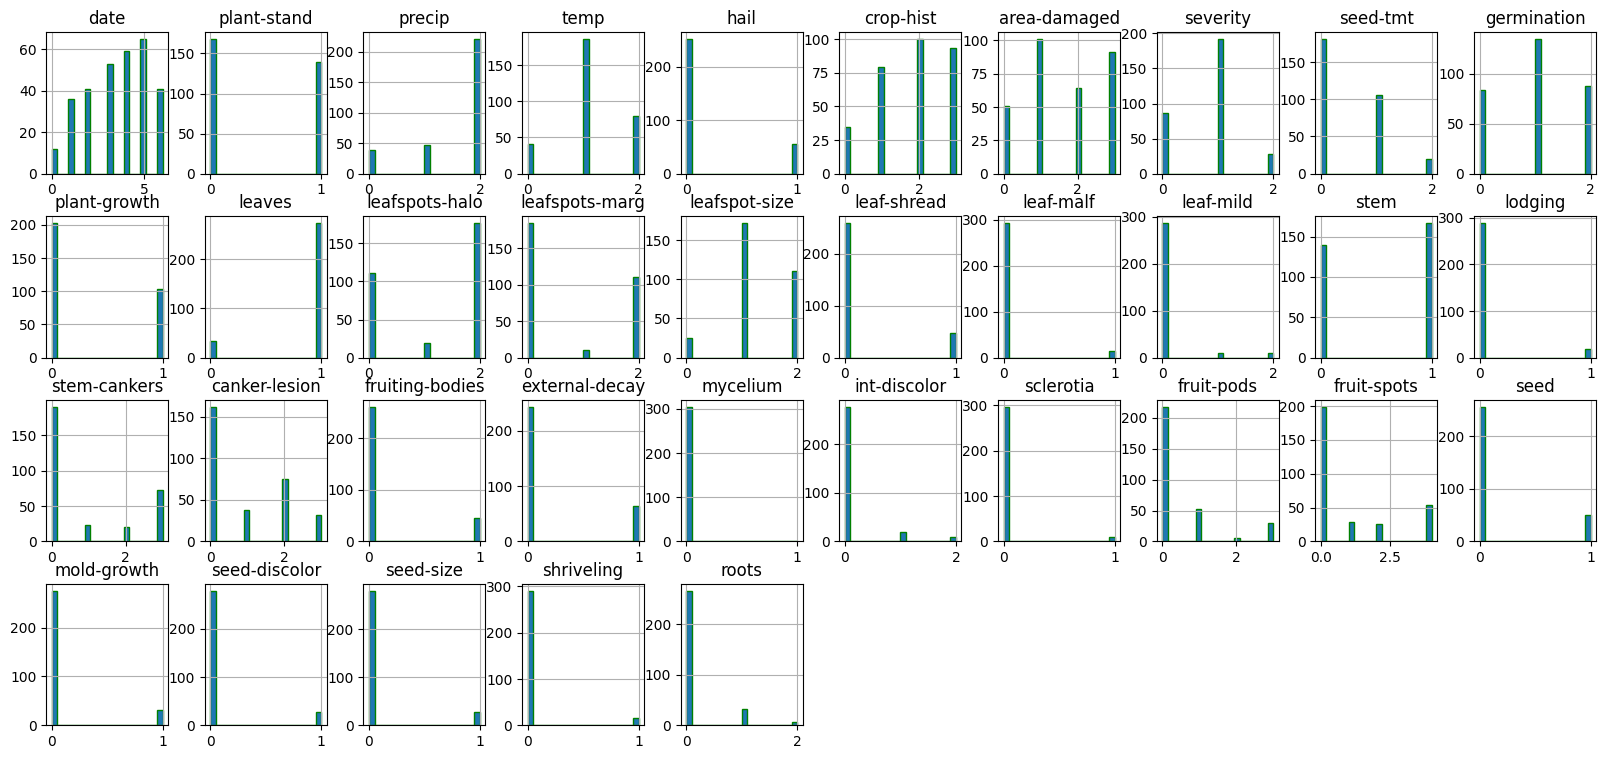

In [12]:
X.hist(figsize=(20,9), layout=(-1,10), bins=20, edgecolor='g');

**Вывод:** имеет место множество бинарных признаков

In [13]:
# характеристики распределения числовых столбцов
X.describe()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,int-discolor,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,...,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,3.530945,0.452769,1.592834,1.127036,0.179153,1.817590,1.635179,0.807818,0.475570,1.013029,...,0.130293,0.032573,0.504886,0.960912,0.166124,0.100977,0.091205,0.087948,0.052117,0.153094
std,1.709696,0.498577,0.705034,0.615820,0.384107,0.993089,1.077306,0.582033,0.617201,0.749614,...,0.423139,0.177807,0.937147,1.522737,0.372799,0.301790,0.288371,0.283681,0.222626,0.419323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000,2.000000,0.000000,3.000000,3.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


<Axes: >

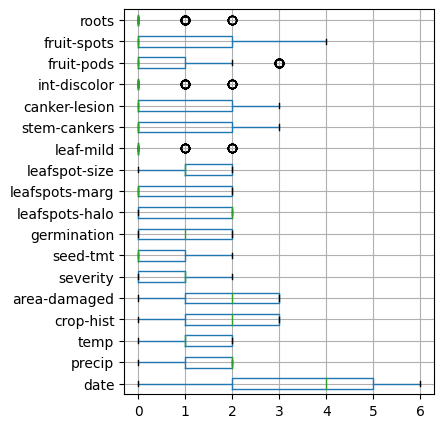

In [14]:
# нормализация признаков
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]
X[non_binary_cols].boxplot(vert=False, figsize=(4, 5))

релевантность выбросов неопределена

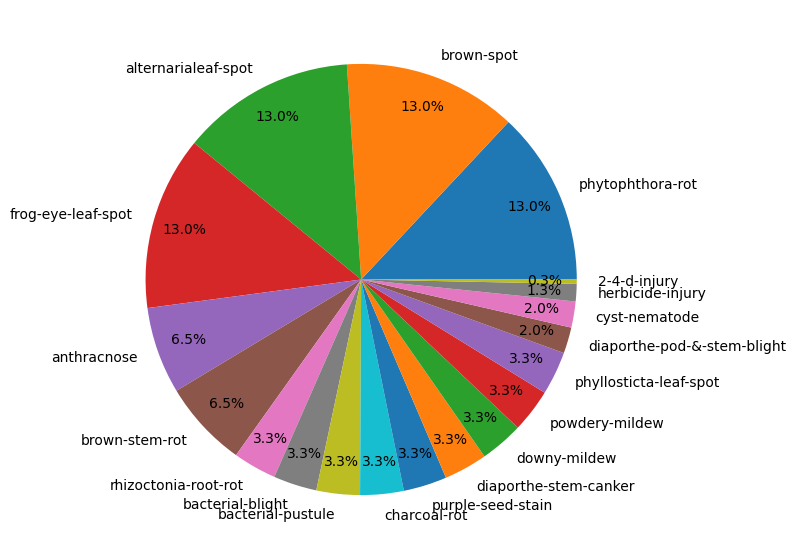

In [15]:
# определение целевой переменной
class_counts = y.value_counts()
labels = [str(label).strip("\(),'") for label in class_counts.index]

plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', pctdistance=0.85);

In [16]:
y.value_counts()

,count
class,
phytophthora-rot,40
brown-spot,40
alternarialeaf-spot,40
frog-eye-leaf-spot,40
anthracnose,20
brown-stem-rot,20
rhizoctonia-root-rot,10
bacterial-blight,10
bacterial-pustule,10


**Ввыод:** есть классы с незначительным количеством объектов.

# Models

In [25]:
# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True)

In [26]:
# кодируем целевую переменную
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

In [27]:
# для получения ROC AUC требуется бинаризировать
n_classes = len(set(y))
classes_in_test = np.unique(y_test_num)
y_test_bin = label_binarize(y_test_num, classes=np.arange(0, 19))

In [29]:
# логистическая регрессия
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(
                                            max_iter=10000,
                                            class_weight='balanced',
                                            multi_class='multinomial'))])

pipe_lr_base.fit(X_train, y_train_num)

y_pred_num = pipe_lr_base.predict(X_test)
all_classes = list(range(len(le.classes_)))

print(classification_report(y_test_num, y_pred_num, labels=all_classes, target_names=le.classes_, zero_division=0))


                             precision    recall  f1-score   support

               2-4-d-injury       0.00      0.00      0.00         0
        alternarialeaf-spot       1.00      0.86      0.92         7
                anthracnose       1.00      0.75      0.86         8
           bacterial-blight       0.75      0.75      0.75         4
          bacterial-pustule       0.00      0.00      0.00         0
                 brown-spot       1.00      1.00      1.00         8
             brown-stem-rot       1.00      1.00      1.00         5
               charcoal-rot       1.00      1.00      1.00         2
              cyst-nematode       1.00      1.00      1.00         1
diaporthe-pod-&-stem-blight       0.67      1.00      0.80         2
      diaporthe-stem-canker       1.00      1.00      1.00         2
               downy-mildew       0.00      0.00      0.00         0
         frog-eye-leaf-spot       0.83      0.83      0.83         6
           herbicide-injury      

In [30]:
y_score = pipe_lr_base.decision_function(X_test)

metrics = get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='LogisticRegression_Baseline',
                       type_multi='ovr',
                       classes_in_test=classes_in_test
)
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.991632,0.903226,0.860606,0.903226,0.879365,0.903226,0.864872,0.90345


**Вывод:** получены хорошие метрики

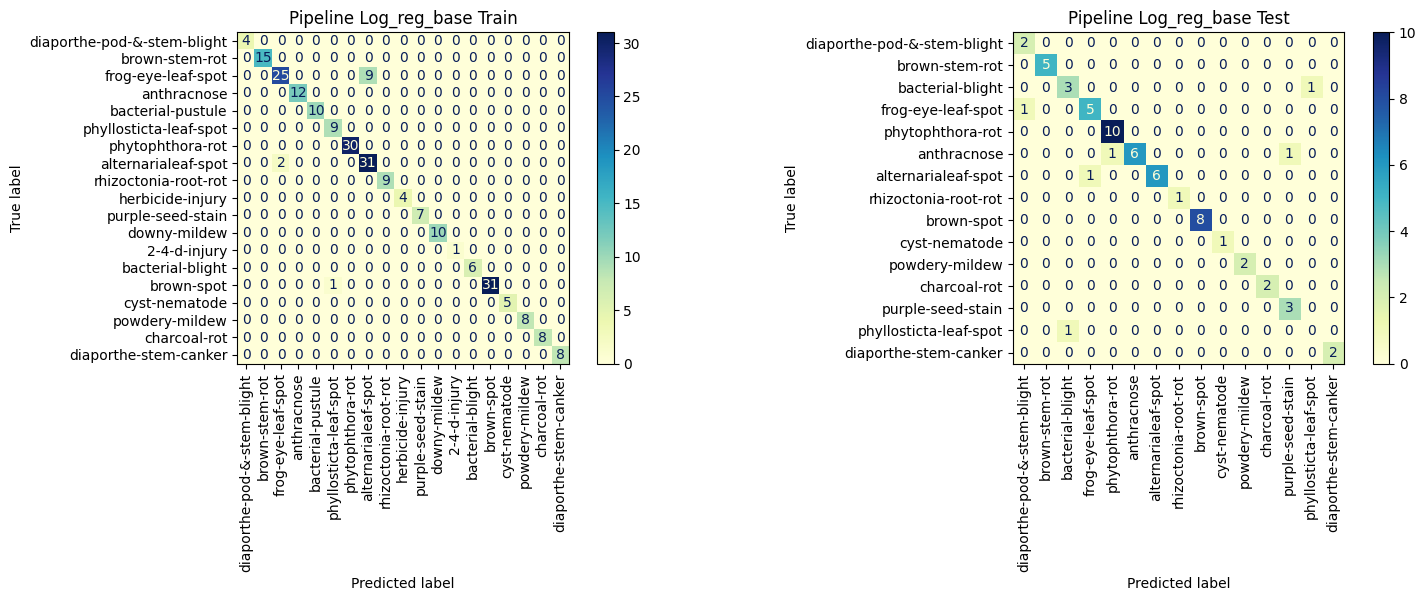

In [31]:
# результаты обучения
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_confusion_matrix(model=pipe_lr_base,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_lr_base,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_lr_base).__name__ + ' Log_reg_base' + ' Train')
ax[1].title.set_text(type(pipe_lr_base).__name__ + ' Log_reg_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Вывод:** в тестовой выборке 17 классов из 19. Модель ошибается в brown-spot и frog-eye-leaf-spot

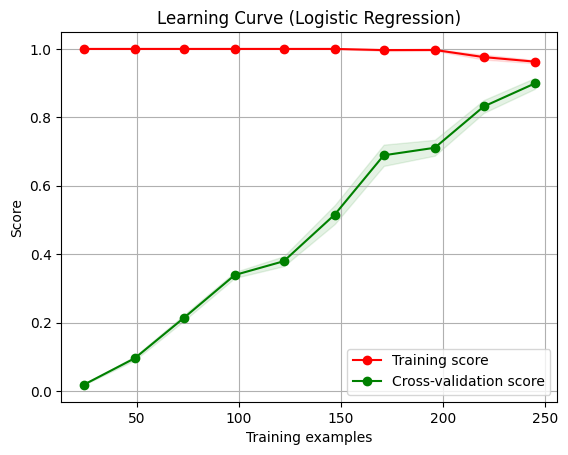

In [32]:
# график зависимости F1 от количества обучающих примеров
train_sizes, train_scores, test_scores = learning_curve(
    pipe_lr_base, X, y, cv=5, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

**Вывод:** отмечено улучшение результатов при увеличинии количества объектов

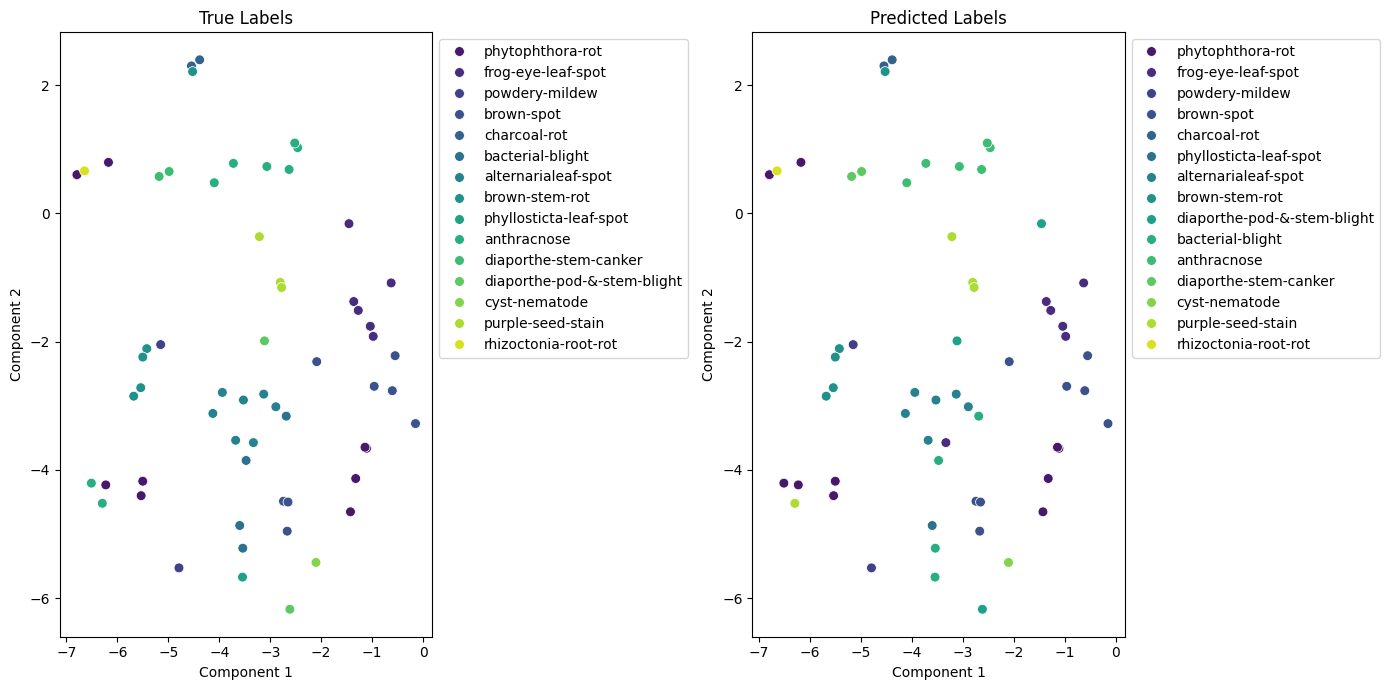

In [37]:
# визуализация истинных меток и предсказаний в 2D
tsne = TSNE(n_components=2)
X_test_2d = tsne.fit_transform(X_test)

df = pd.DataFrame(X_test_2d, columns=['Component 1', 'Component 2'])
df['True Label'] = le.inverse_transform(y_test_num)
df['Predicted Label'] = le.inverse_transform(y_pred_num)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='True Label', palette='viridis', legend='full', s=50)
plt.title('True Labels')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Predicted Label', palette='viridis', legend='full', s=50)
plt.title('Predicted Labels')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout()
plt.show()

**Вывод:** визуализируется малое количество кластеров.

In [39]:
# Random Forest
pipe_rf_base = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

pipe_rf_base.fit(X_train, y_train_num)

y_pred_num = pipe_rf_base.predict(X_test)

all_classes = list(range(len(le.classes_)))
print(classification_report(y_test_num, y_pred_num, labels=all_classes, target_names=le.classes_, zero_division=0))

                             precision    recall  f1-score   support

               2-4-d-injury       0.00      0.00      0.00         0
        alternarialeaf-spot       1.00      1.00      1.00         7
                anthracnose       1.00      0.88      0.93         8
           bacterial-blight       1.00      1.00      1.00         4
          bacterial-pustule       0.00      0.00      0.00         0
                 brown-spot       0.80      1.00      0.89         8
             brown-stem-rot       1.00      1.00      1.00         5
               charcoal-rot       1.00      1.00      1.00         2
              cyst-nematode       1.00      1.00      1.00         1
diaporthe-pod-&-stem-blight       0.67      1.00      0.80         2
      diaporthe-stem-canker       1.00      1.00      1.00         2
               downy-mildew       0.00      0.00      0.00         0
         frog-eye-leaf-spot       1.00      0.67      0.80         6
           herbicide-injury      

In [40]:
y_score = pipe_rf_base.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='RF_Baseline',
                       type_multi='ovr',
                       classes_in_test=classes_in_test)
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.991632,0.903226,0.860606,0.903226,0.879365,0.903226,0.864872,0.903450
0,RF_Baseline,0.998600,0.935484,0.891717,0.935484,0.902778,0.935484,0.891640,0.927445


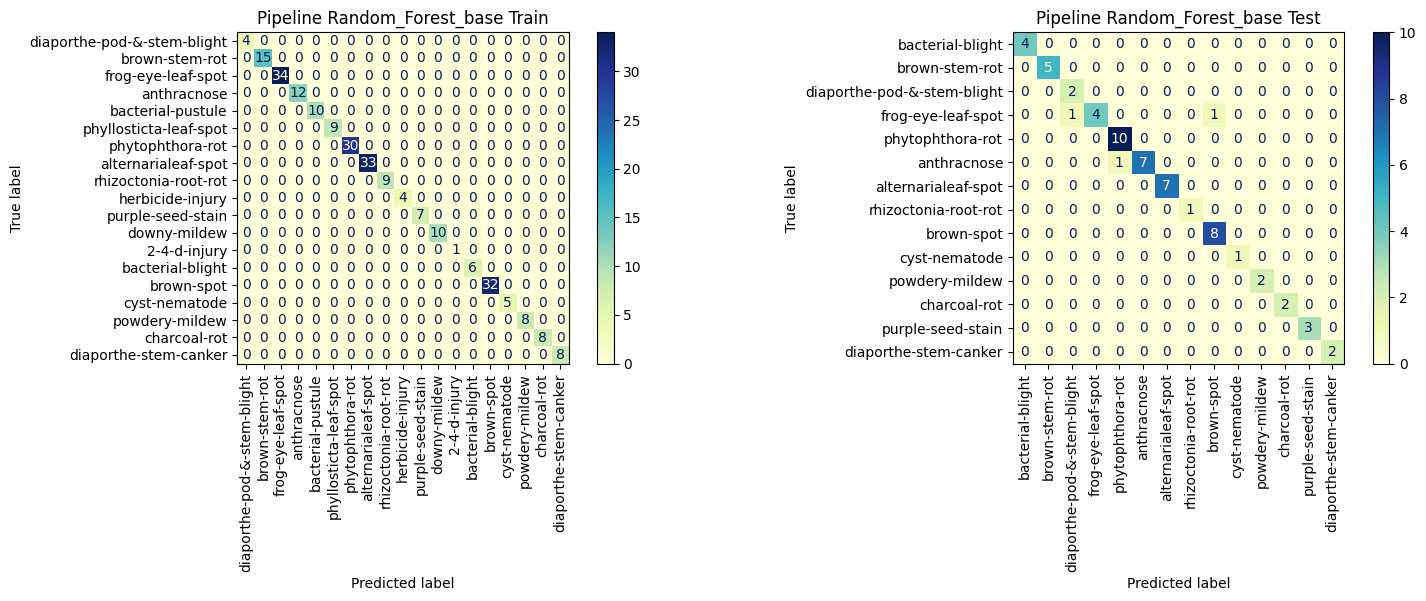

In [41]:
# результаты обучения
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_confusion_matrix(model=pipe_rf_base,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_rf_base,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_rf_base).__name__ + ' Random_Forest_base' + ' Train')
ax[1].title.set_text(type(pipe_rf_base).__name__ + ' Random_Forest_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Вывод:** в отличие от предыдущей модели, здесь в тестовой выборке ошибки в классах frog-eye-leaf-spot и alternarialeaf-spot

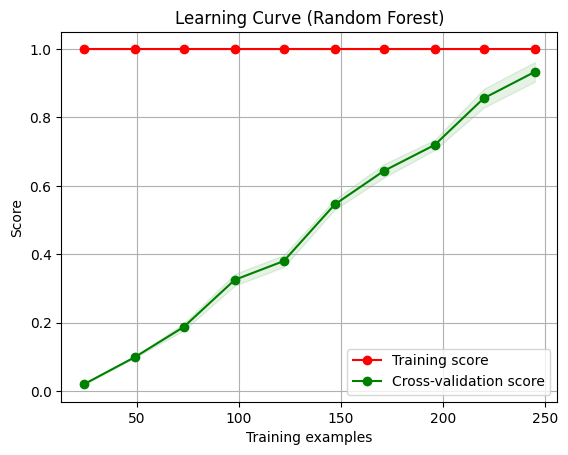

In [42]:
# график зависимости F1 от количества обучающих примеров
train_sizes, train_scores, test_scores = learning_curve(
    pipe_rf_base, X, y, cv=5, scoring='f1_weighted', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

**Вывод:** график схож с результатами предыдущей модели

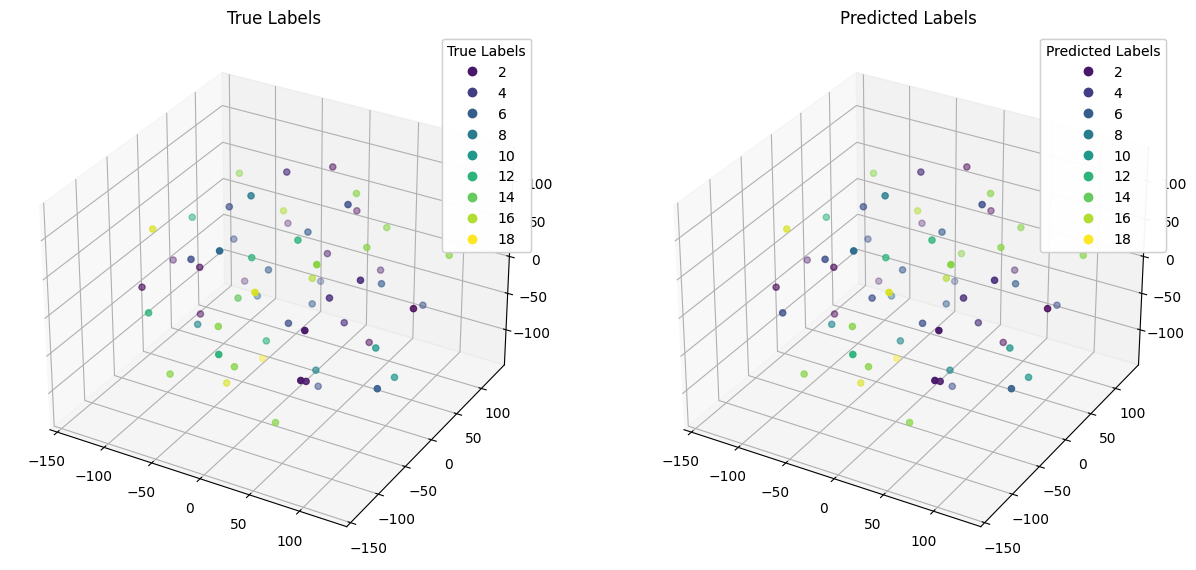

In [44]:
# визуализация истинных меток и предсказаний в 3D
tsne_3d = TSNE(n_components=3)
X_test_3d = tsne_3d.fit_transform(X_test)

df_3d = pd.DataFrame(X_test_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df_3d['True Label'] = le.inverse_transform(y_test_num)
df_3d['Predicted Label'] = le.inverse_transform(y_pred_num)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(df_3d['Component 1'], df_3d['Component 2'], df_3d['Component 3'], c=y_test_num, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="True Labels")
ax.add_artist(legend1)
ax.set_title('True Labels')

ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(df_3d['Component 1'], df_3d['Component 2'], df_3d['Component 3'], c=y_pred_num, cmap='viridis')
legend2 = ax.legend(*scatter.legend_elements(), title="Predicted Labels")
ax.add_artist(legend2)
ax.set_title('Predicted Labels')

plt.show()

**Вывод:** по-прежнему визуализируется малое количество кластеров.

In [51]:
# SVC
pipe_svc_base = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(class_weight='balanced', probability=True))
])

pipe_svc_base.fit(X_train, y_train_num)

y_pred_num = pipe_svc_base.predict(X_test)
all_classes = list(range(len(le.classes_)))
print(classification_report(y_test_num, y_pred_num, labels=all_classes, target_names=le.classes_, zero_division=0))

                             precision    recall  f1-score   support

               2-4-d-injury       0.00      0.00      0.00         0
        alternarialeaf-spot       1.00      1.00      1.00         7
                anthracnose       0.88      0.88      0.88         8
           bacterial-blight       1.00      0.75      0.86         4
          bacterial-pustule       0.00      0.00      0.00         0
                 brown-spot       0.89      1.00      0.94         8
             brown-stem-rot       1.00      1.00      1.00         5
               charcoal-rot       1.00      1.00      1.00         2
              cyst-nematode       1.00      1.00      1.00         1
diaporthe-pod-&-stem-blight       1.00      1.00      1.00         2
      diaporthe-stem-canker       1.00      1.00      1.00         2
               downy-mildew       0.00      0.00      0.00         0
         frog-eye-leaf-spot       1.00      0.67      0.80         6
           herbicide-injury      

In [52]:
y_score = pipe_svc_base.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='SVC_Baseline',
                       type_multi='ovo',
                       classes_in_test=classes_in_test)
])

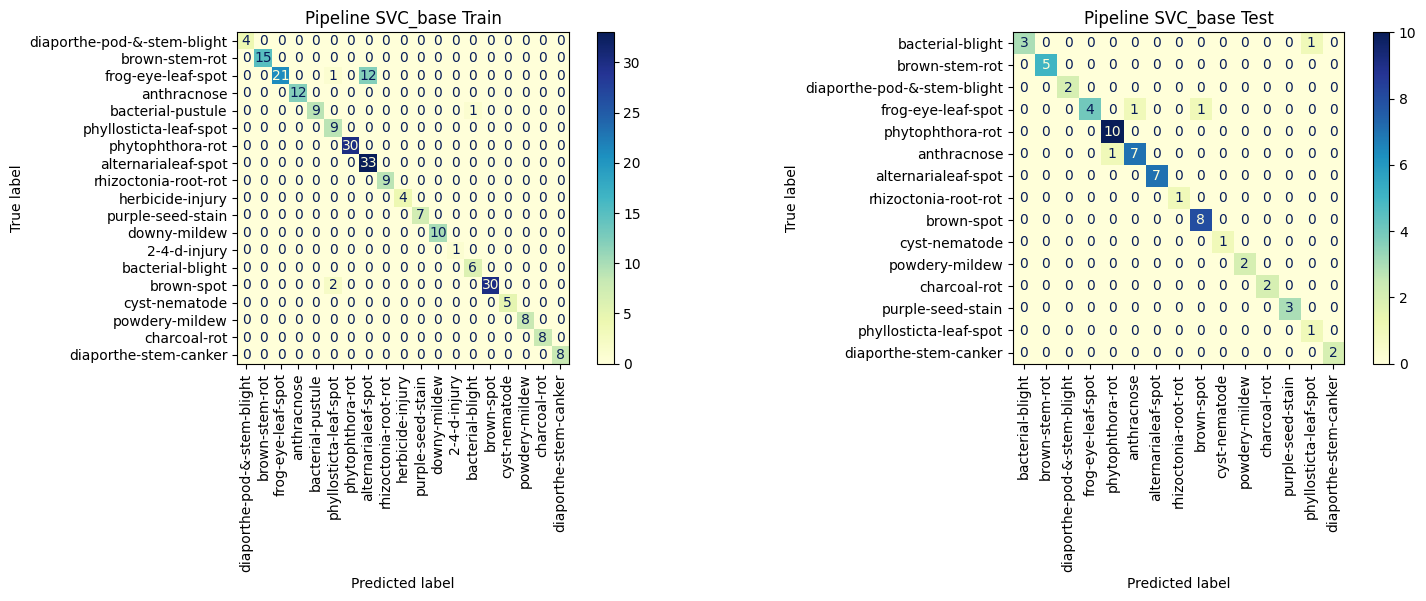

In [53]:
# результаты обучения
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_confusion_matrix(model=pipe_svc_base,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_svc_base,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_svc_base).__name__ + ' SVC_base' + ' Train')
ax[1].title.set_text(type(pipe_svc_base).__name__ + ' SVC_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Вывод:** есть сходство с первой моделью

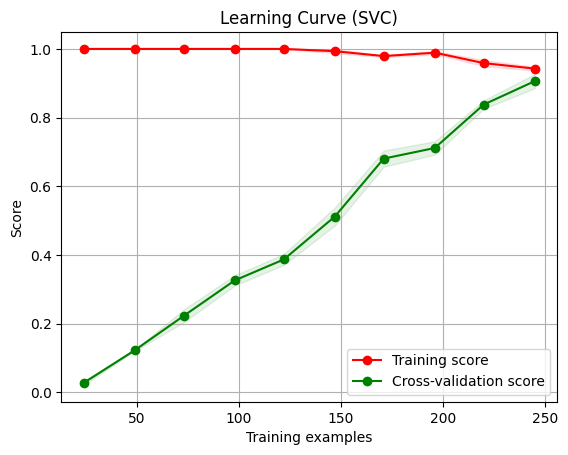

In [54]:
# график зависимости F1 от количества обучающих примеров
train_sizes, train_scores, test_scores = learning_curve(
    pipe_svc_base, X, y, cv=5,
    scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (SVC)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

**Вывод:** результат схож с предыдущими моделями

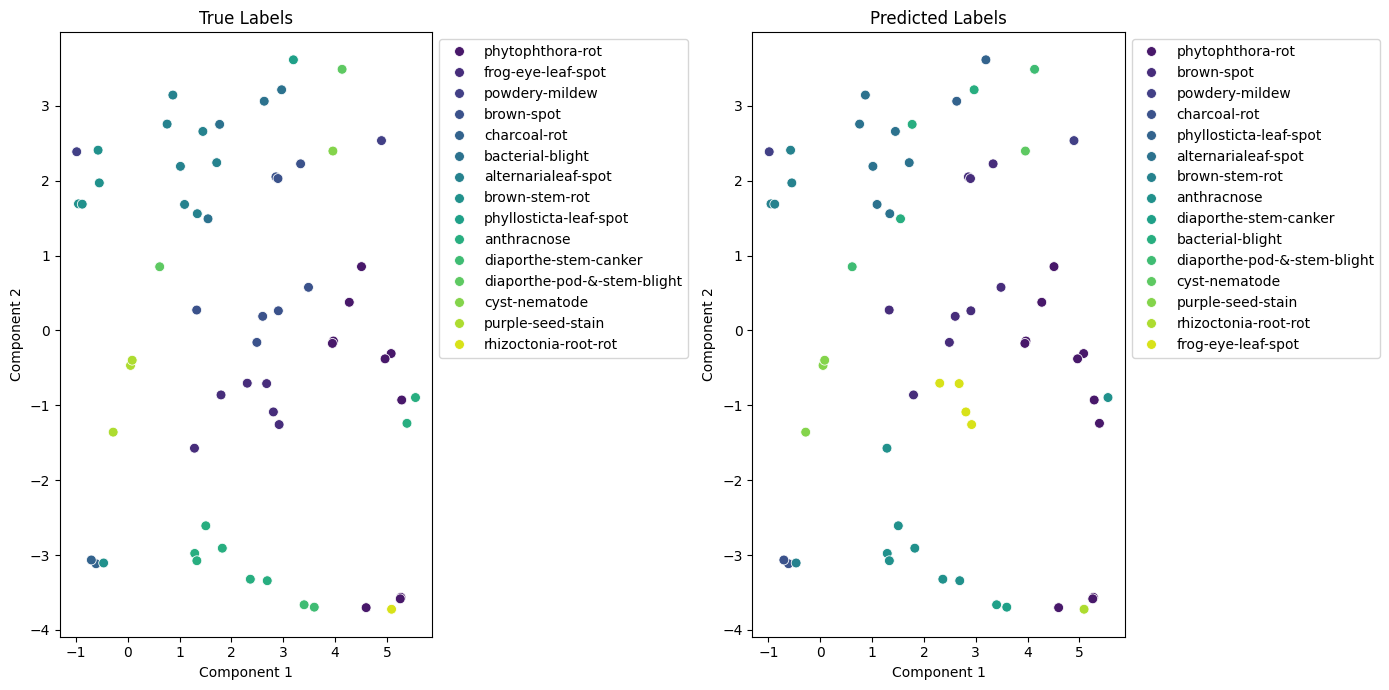

In [56]:
# визуализация истинных меток и предсказаний в 2D
tsne = TSNE(n_components=2)
X_test_2d = tsne.fit_transform(X_test)

df = pd.DataFrame(X_test_2d, columns=['Component 1', 'Component 2'])
df['True Label'] = le.inverse_transform(y_test_num)
df['Predicted Label'] = le.inverse_transform(y_pred_num)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='True Label', palette='viridis', legend='full', s=50)
plt.title('True Labels')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Predicted Label', palette='viridis', legend='full', s=50)
plt.title('Predicted Labels')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout()
plt.show()

## Обобщение результатов

In [62]:
metrics = metrics.reset_index(drop=True)
metrics = metrics.sort_values("F1_weighted", ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: blue" if v else "" for v in is_max]

styled_metrics = metrics.style.apply(highlight_max, subset=["F1_weighted"])

styled_metrics

,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,0.991764,0.935484,0.944865,0.935484,0.952778,0.935484,0.939491,0.934653
1,0.998600,0.935484,0.891717,0.935484,0.902778,0.935484,0.891640,0.927445
2,0.991632,0.903226,0.860606,0.903226,0.879365,0.903226,0.864872,0.903450


**Вывод:** все модели показли хорошие результаты, наилучшие у SVC.